<a href="https://colab.research.google.com/github/N3wBaz/ml-intro/blob/main/4_overfitting_regularization/overfitting_regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overfitting and Regularization

## Imports

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config

In [ ]:
set_config(display='diagram')

## Settings

In [ ]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [ ]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

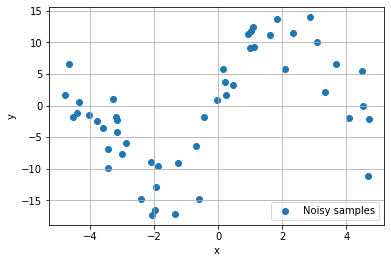

In [ ]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

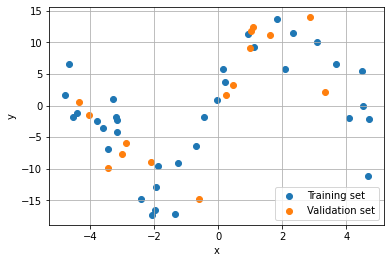

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

In [ ]:
y_train

array([ -1.10771616,   0.84986647,  -9.62110024,   3.70972424,
        -2.36319095,   5.83708039, -16.53330524,  -1.8815588 ,
       -11.1506254 ,   1.0883081 ,  -9.05957818, -14.72254274,
         5.71746212,   5.48508317,  -6.81897956,  -1.80751907,
        -2.14124891, -12.83476672,  -0.09034969,  -3.48222266,
        11.50001273,  -2.03019037,  10.03142993, -17.18409407,
        -2.48182149,   1.67461593, -17.32081894,  -6.32825039,
        -4.15121484,   9.31494651,   6.5817456 ,   6.58351686,
        -1.83803375,  11.27589865,  13.68530977])

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [ ]:
PolynomialFeatures(degree=4, include_bias=False).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.],
       [  3.,   9.,  27.,  81.],
       [  4.,  16.,  64., 256.]])

In [ ]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000, tol=1e-2)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()), ('reg', LinearRegression())])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg',
                 Lasso(alpha=0.1, max_iter=50000, random_state=42, tol=0.01))])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Ridge(alpha=0.1, max_iter=50000, random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

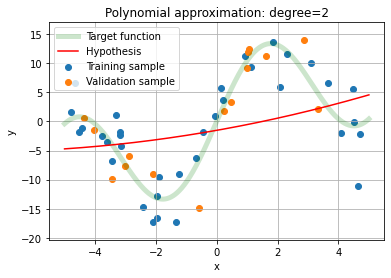

In [ ]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

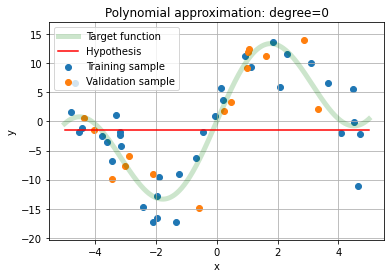

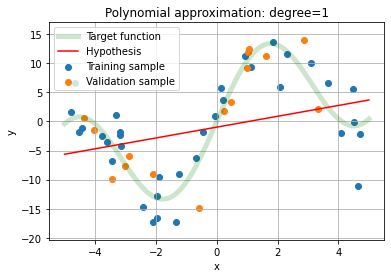

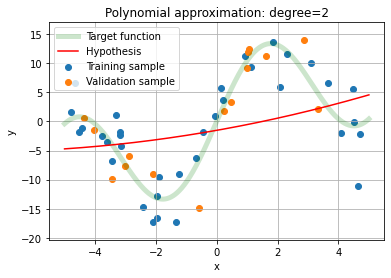

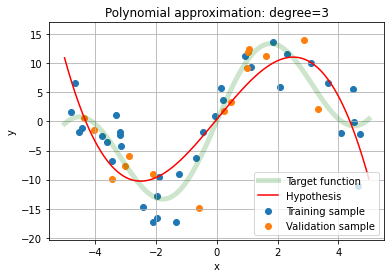

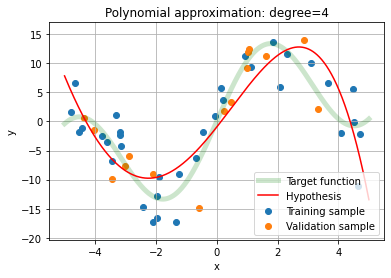

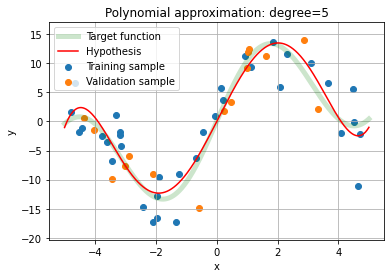

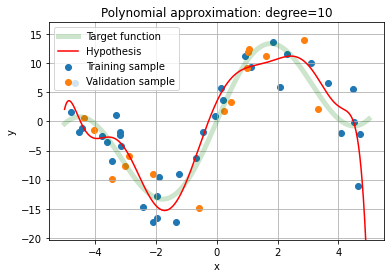

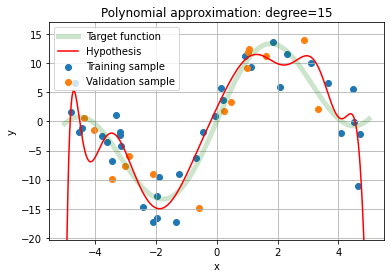

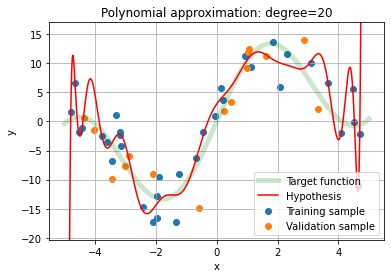

In [ ]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

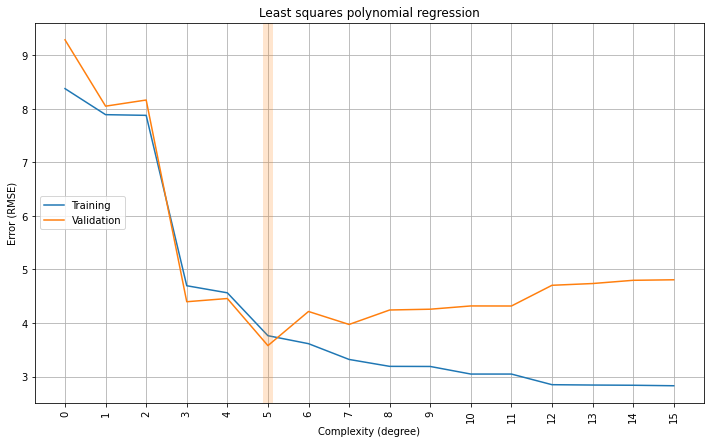

In [ ]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(12, 7))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        # plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.plot(x, custom_metric, alpha=0.6, lw=4, ls='dotted', color='magenta', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [ ]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

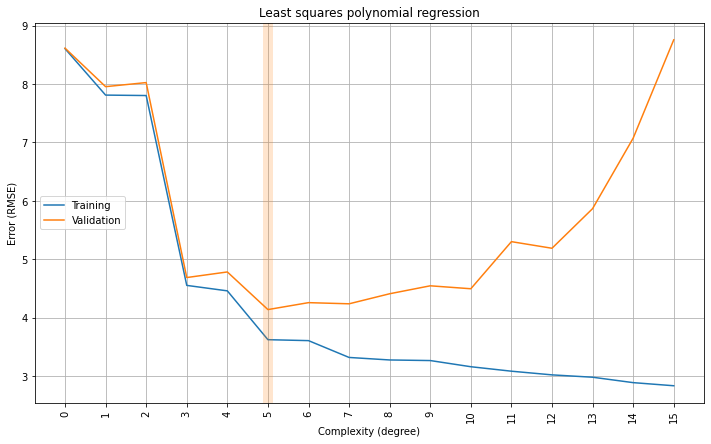

In [ ]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [ ]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([2.81292778]),
 array([2.80049884, 0.45166501]),
 array([ 30.87315584,   1.48752361, -54.60227825,  -1.63699842,
         26.62792933]),
 array([  33.63850705,  -41.86346242,  -70.48743112,  278.98853452,
          27.48125634, -656.36383501,   59.32988346,  651.64795186,
         -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

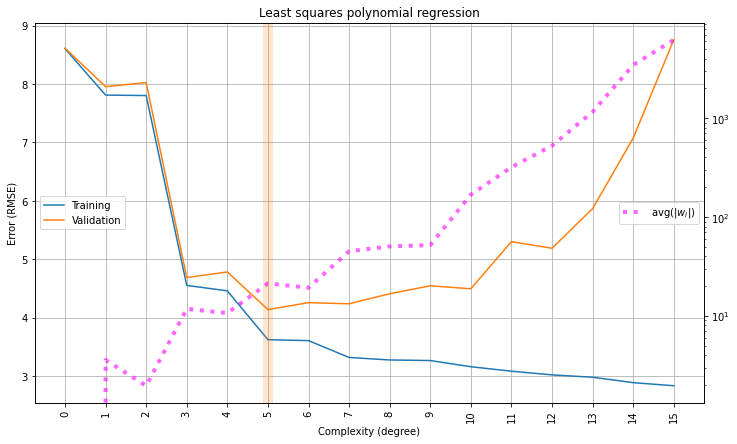

In [ ]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam�s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

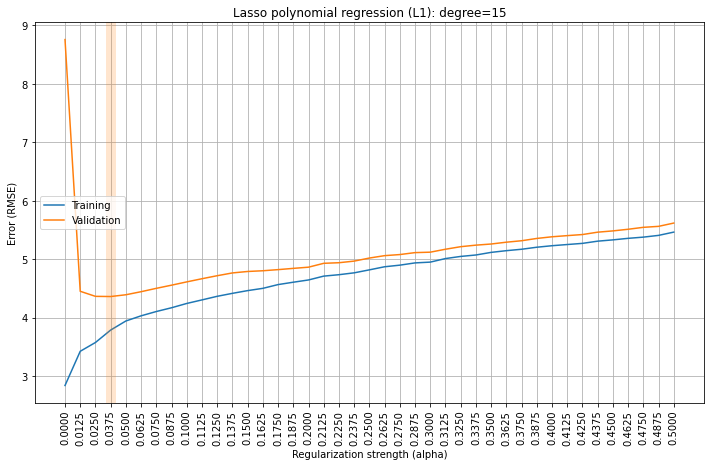

In [ ]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

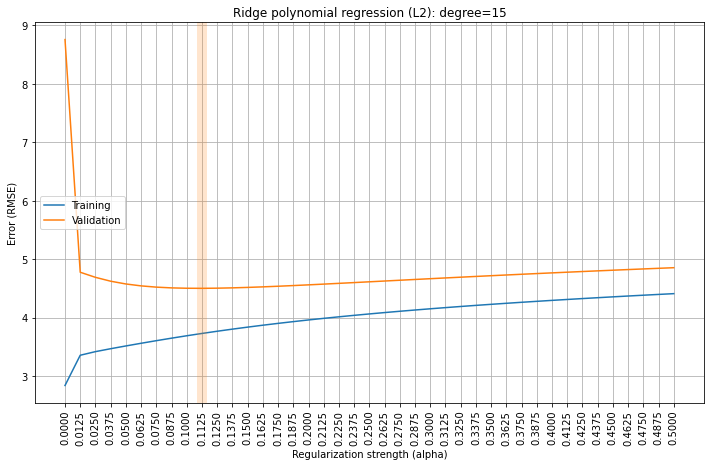

In [ ]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## **Part 3: Homework assignment (10 points)**

### **Excercise 1** - Overfiting and Underfitting (2 points)

Let's work with the diabetes dataset

In [ ]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X_diabetes = pd.DataFrame(data['data'], columns=data['feature_names'])
y_diabetes = pd.DataFrame(data['target'], columns=['target'])
print(data['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

Перенастроим функцию создания модели(make_model) для того, чтобы можно было применять PolynomialFeatures не ко всем признакам, а также список со степенями DEGREES (чтобы не начинался с 0, так как PolynomialFeatures выдает ошибку)

In [ ]:
DEGREES = np.linspace(1, 15, 15, dtype=int)

In [ ]:

from sklearn.compose import ColumnTransformer


def make_model(degree, col, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000, tol=1e-2)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 

    preprocessor = ColumnTransformer([('new', PolynomialFeatures(degree, include_bias=(degree == 0)), col)], remainder='passthrough')
    
    return Pipeline([
                     ('preprocessor', preprocessor), 
                     ('sca', StandardScaler()),
                     ('reg', regressor)
    ])

Разбиваем данные на тренировочные и валидационные

In [ ]:
X_dia_train, X_dia_valid, y_dia_train, y_dia_valid = train_test_split(X_diabetes, y_diabetes, test_size=0.3, random_state=SEED)

В связи с ограничением вычислительных мощностей, берем некоторое количество признаков  и считаем зависимость ошибки модели от степеней признаков.

In [ ]:
columns = ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3']

rmse_train, rmse_valid = [], []
for degree in DEGREES:
    dia = make_model(degree, col=columns).fit(X_dia_train, y_dia_train)
    rmse_train.append(rmse(dia.predict(X_dia_train), y_dia_train))
    rmse_valid.append(rmse(dia.predict(X_dia_valid), y_dia_valid))

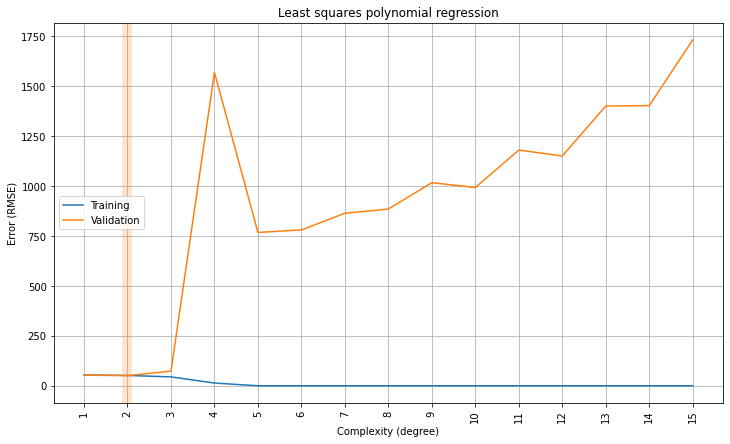

In [ ]:
# график
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

Выведем данные ближе к началу координат, чтобы лучше рассмотреть

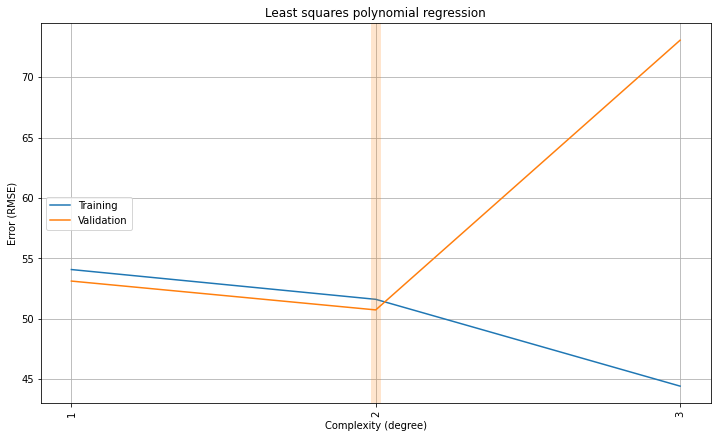

In [ ]:
rmse_train, rmse_valid = [], []
for degree in [1, 2, 3]:
    dia = make_model(degree, col=columns).fit(X_dia_train, y_dia_train)
    rmse_train.append(rmse(dia.predict(X_dia_train), y_dia_train))
    rmse_valid.append(rmse(dia.predict(X_dia_valid), y_dia_valid))

plot_fitting_graph([1, 2, 3], rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

По графикам видно,что с увеличением количества признаков (после функции PolynomialFeatures), то происходит взрывной рост ошибки начиная с 3 степени, пик на 4 степени с последующим падением на степени 5 и пологим ростом с увеличением степени PolynomialFeatures. Судя по графику, то после 2 степени происходи переобучение модели. Это видно по увеличению ошибки на валидационном датасете, в то время как ошибка на тренировочном датасете уменьшается. Для того чтобы это было хорошо видно расхождение был отдельно построен график начала степенного ряда. Переобучение происходит на степени 3. Разница между MSE на тренировочных данных и валидационных которую мы видим на степени 3 и далее. Это происходит за счет мультиколлиарности, появившейся из-за наличия полиномиальных признаков (степенных или полученых путем перемножением признаков), которая только усиливается с увеличением степени.

   Если говорить про недообученность модели, то мы можем наблюдать его только на 1 степени, так как ко 2 степени происходит небольшое уменьшение ошибки на трейне и валидации, далее переобучение. Оптимальная степень признаков для модели 2.

Apply model for diabetes dataset with polynomial feature engineering of different degrees. Plot the dependence of train and test error on polynomial degree. Highlight a degree with the best test error. Which degrees cause overfitting/underfitting? Why?

### **Excercise 2** - Magnitude (3 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

In [ ]:
columns = ['age', 'sex', 'bmi', 'bp', 's1', 's2']

rmse_train, rmse_valid = [], []
avg_coef = []
for alpha in tqdm(ALPHAS):
    dia = make_model(degree=15, penalty='L1', alpha=alpha, col=columns).fit(X_dia_train, y_dia_train)
    rmse_train.append(rmse(dia.predict(X_dia_train), y_dia_train))
    rmse_valid.append(rmse(dia.predict(X_dia_valid), y_dia_valid))

    avg_coef.append(np.mean(np.sum(np.abs(dia['reg'].coef_))))        


  0%|          | 0/41 [00:00<?, ?it/s]

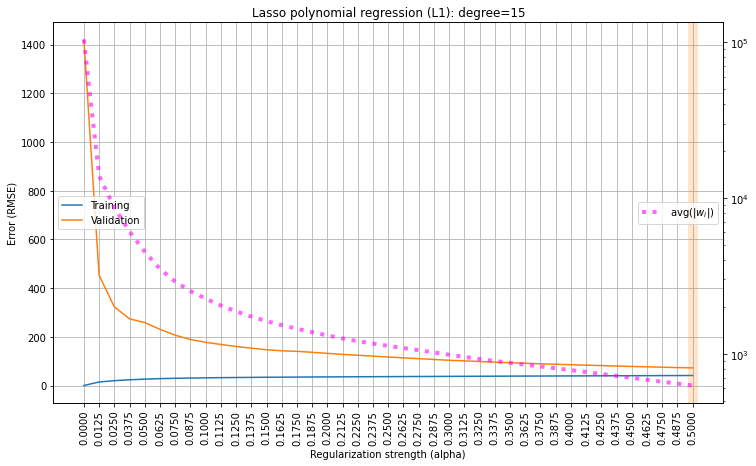

In [ ]:
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Lasso polynomial regression (L1): degree=15')

#### L2

In [ ]:
columns = ['age', 'sex', 'bmi', 'bp','s1']
rmse_train, rmse_valid = [], []
avg_coef = []

for alpha in tqdm(ALPHAS):    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha, col=columns), 
                             X_diabetes, y_diabetes, cv=3,
                             return_train_score=True,
                             return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    avg_coef.append(        
    # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))

  0%|          | 0/41 [00:00<?, ?it/s]

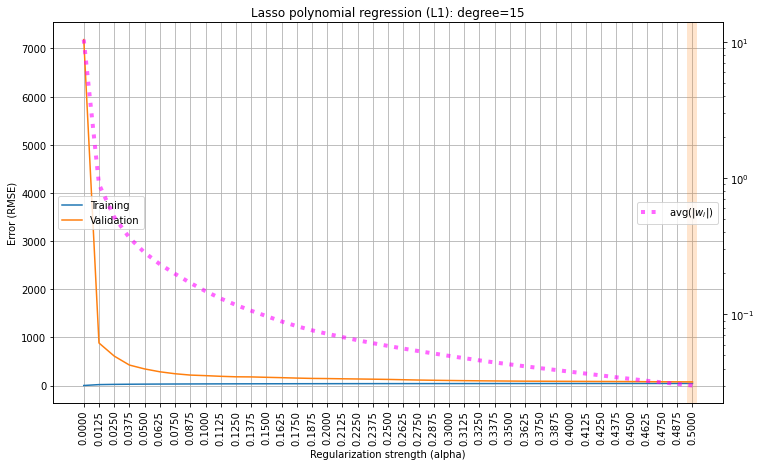

In [ ]:
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Lasso polynomial regression (L1): degree=15')

In [ ]:
columns = ['age', 'sex', 'bmi', 'bp','s1', 's2']
rmse_train, rmse_valid = [], []
avg_coef = []
for alpha in tqdm(ALPHAS):    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha, col=columns), 
                             X_diabetes, y_diabetes, cv=5,
                             return_train_score=True,
                             return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    avg_coef.append(        
    # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))


  0%|          | 0/41 [00:00<?, ?it/s]

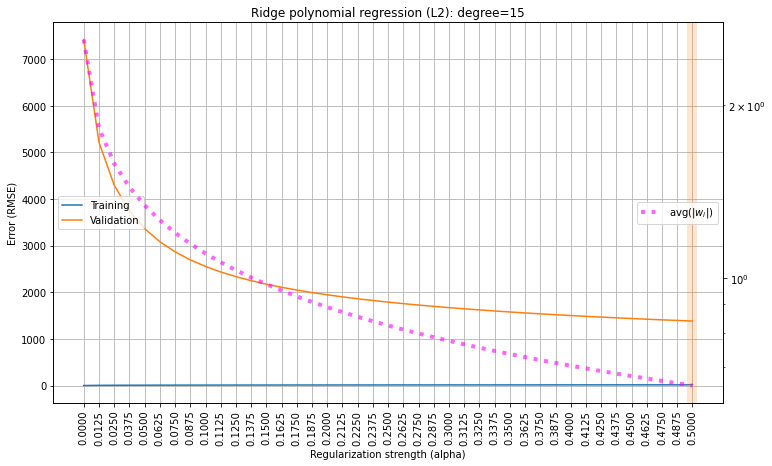

In [ ]:
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Ridge polynomial regression (L2): degree=15')

#### Summary

По построенным графикам для L1 и L2 регуляризации видно с увеличнием коэффициента alpha происходит увеличение влияния регуляризации на веса модели. На графиках средний арифметических вес показан серым. Так же происходит уменьшение ошибки RMSE и на тренировочных и на валидационных данных. На графике оптимальный коэффициент aplha для L1 и L2 регуляризации показан вертикально бледно-оранжевой линией и равен alpha = 0.5

### **Excercise 3** - Sparsity (3 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

Посчитаем относительное количество нулевых коэффициентов линейной регрессии с L1 регуляризацией.

In [ ]:
## your code

columns = ['age', 'sex', 'bmi', 'bp']


avg_coef = []
avg_coef_zero = []
for alpha in tqdm(ALPHAS):
    dia = make_model(degree=15, penalty='L1', alpha=alpha, col=columns).fit(X_dia_train, y_dia_train)
    coeff = dia['reg'].coef_.squeeze()
    avg_coef_zero.append((len(coeff) - np.count_nonzero(coeff)) * 100 / len(coeff))
    avg_coef.append(np.count_nonzero(coeff) * 100 / len(coeff))


  0%|          | 0/41 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.444e+04, tolerance: 1.900e+04
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


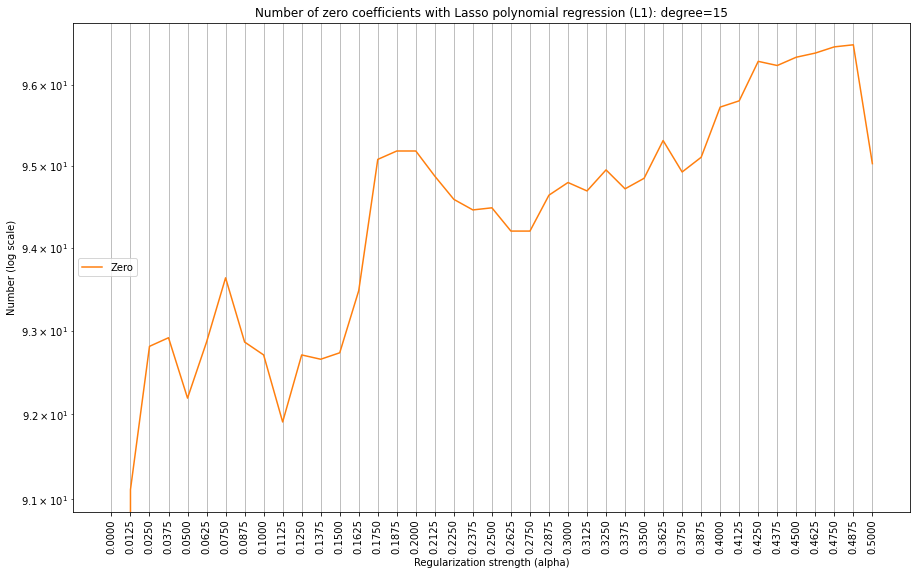

In [ ]:

plt.figure(figsize=(15, 9))
plt.plot(ALPHAS, avg_coef_zero, color='C1', label='Zero')
plt.title('Number of zero coefficients with Lasso polynomial regression (L1): degree=15')
plt.xlabel('Regularization strength (alpha)')
plt.ylabel('Number (log scale)')
plt.grid(True)
plt.yscale('log')
plt.xticks(ALPHAS, rotation='vertical')
plt.legend(loc='center left')        
     
plt.show()


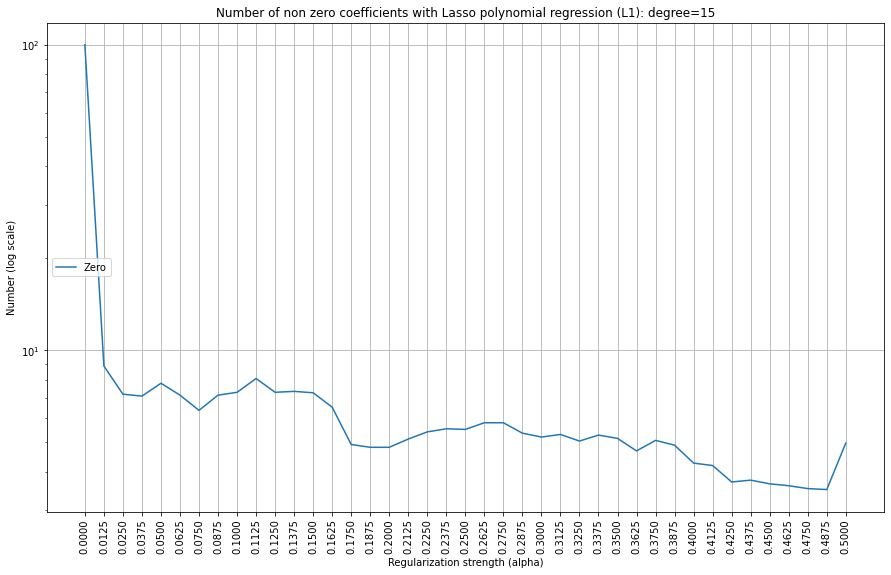

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(ALPHAS, avg_coef, label='Zero')
plt.title('Number of non zero coefficients with Lasso polynomial regression (L1): degree=15')
plt.xlabel('Regularization strength (alpha)')
plt.ylabel('Number (log scale)')
plt.grid(True)
plt.yscale('log')
plt.xticks(ALPHAS, rotation='vertical')
plt.legend(loc='center left')        
     
plt.show()

#### L2

In [ ]:
columns = ['age', 'sex', 'bmi', 'bp']

avg_coef = []
avg_coef_zero = []
for alpha in tqdm(ALPHAS):
    dia = make_model(degree=15, penalty='L2', alpha=alpha, col=columns).fit(X_dia_train, y_dia_train)
    coeff = dia['reg'].coef_.squeeze()
    avg_coef_zero.append(len(coeff) - np.count_nonzero(coeff))
    avg_coef.append(np.count_nonzero(coeff))

  0%|          | 0/41 [00:00<?, ?it/s]

In [ ]:
print(avg_coef_zero)
print(avg_coef)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[3881, 3881, 3881, 3881, 3881, 3881, 3881, 3881, 3881, 3881, 3881, 3881, 3881, 3881, 3881, 3881, 3881, 3881, 3881, 3881, 3881, 3881, 3881, 3881, 3881, 3881, 3881, 3881, 3881, 3881, 3881, 3881, 3881, 3881, 3881, 3881, 3881, 3881, 3881, 3881, 3881]


#### Summary

После подсчета нулевых коэффициентов линейной регрессии с L1 регуляризации можно заметить, что с увеличением коэффициента alpha происходит увеличение нулевых весов до 90% и их количество увеличевается. "*Регуляризация Lasso (L1) позволяет снизить размерность и упростить регрессионную модель, за счёт зануления коэффициентов некоторых признаков.*" 

Таким образом, с регрессией L1 модель может полностью избавиться от шумов в данных.

L2 регуляризация не выявила нулевых коэффициентов ни при каких значениях aplha.

### **Excercise** **4** - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Is scaling important? What are the underlying reasons?

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**) on the dataset below. Check coefficients.

In [ ]:
def target_function_hw(x):
    return 2 * x

def generate_samples_hw():
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    
    np.random.seed(SEED+1)
    x_noise = np.random.uniform(*[x * 100 for x in RANGE], size=N_SAMPLES)
    x_noise2 = np.random.normal(100, 50, size=N_SAMPLES)
    
    y = target_function_hw(x) + np.random.normal(scale=4, size=N_SAMPLES)
    
    return np.concatenate([x.reshape(-1, 1) / 100, 
                           x_noise.reshape(-1, 1),
                           x_noise2.reshape(-1, 1)], axis=1), y

X_hw, y_hw = generate_samples_hw()


for i in range(X_hw.shape[1]):
    print(f'Min of feature {i}: {min(X_hw[:, i]):.2f}, max: {max(X_hw[:, i]):.2f}')

Min of feature 0: -0.05, max: 0.05
Min of feature 1: -494.87, max: 493.57
Min of feature 2: -2.35, max: 213.31


Слегка изменим функцию make_model для того, чтобы проще было делать 4-е задание.

In [ ]:
# Перепишем функцию создания модели

def make_model(alpha=0, penalty=None, scale=False):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000, tol=1e-2)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    if scale:             
        return Pipeline([
            ('sca', StandardScaler()),
            ('reg', regressor)
        ])
    return Pipeline([
            ('reg', regressor)
        ])

#### L1

In [ ]:
## your code

rmse_scale = []
model_nonscale = make_model(penalty='L1', alpha=alpha).fit(X_hw, y_hw)
model_scale = make_model(penalty='L1', alpha=alpha, scale=True).fit(X_hw, y_hw)

print('Модель с необработанными данными')
print(f"RMSE : {rmse(model_nonscale.predict(X_hw), y_hw)}, коэффициенты : {model_nonscale['reg'].coef_}")
print('Модель с стандартизованными данными')
print(f"RMSE : {rmse(model_scale.predict(X_hw), y_hw)}, коэффициенты : {model_scale['reg'].coef_}")


Модель с необработанными данными
RMSE : 6.470753262509002, коэффициенты : [ 0.         -0.00019299 -0.0174798 ]
Модель с стандартизованными данными
RMSE : 4.036801696636171, коэффициенты : [ 4.63705155  0.         -0.12603086]


#### L2

In [ ]:
## your code

rmse_scale = []
model_nonscale = make_model(penalty='L2', alpha=alpha).fit(X_hw, y_hw)
model_scale = make_model(penalty='L2', alpha=alpha, scale=True).fit(X_hw, y_hw)

print('Модель с необработанными данными')
print(f"RMSE : {rmse(model_nonscale.predict(X_hw), y_hw)}, коэффициенты : {model_nonscale['reg'].coef_}")
print('Модель с стандартизованными данными')
print(f"RMSE : {rmse(model_scale.predict(X_hw), y_hw)}, коэффициенты : {model_scale['reg'].coef_}")

Модель с необработанными данными
RMSE : 6.171916884869858, коэффициенты : [ 1.34724952e+01 -1.50887784e-04 -1.72800879e-02]
Модель с стандартизованными данными
RMSE : 3.9759655070593736, коэффициенты : [ 5.06550145  0.12151468 -0.60342419]


Выведем минимум и максимум данных по признакам до и после стандартизации.

In [ ]:
sca = StandardScaler()
X_hw_scale = sca.fit_transform(X_hw)
print("Необработанные данные")
for i in range(X_hw.shape[1]):
    print(f'Min of feature {i}: {min(X_hw[:, i]):.2f}, max: {max(X_hw[:, i]):.2f}')

print("\nСтандартизованные данные")
for i in range(X_hw_scale.shape[1]):
    print(f'Min of feature {i}: {min(X_hw_scale[:, i]):.2f}, max: {max(X_hw_scale[:, i]):.2f}')

Необработанные данные
Min of feature 0: -0.05, max: 0.05
Min of feature 1: -494.87, max: 493.57
Min of feature 2: -2.35, max: 213.31

Стандартизованные данные
Min of feature 0: -1.49, max: 1.83
Min of feature 1: -1.66, max: 1.54
Min of feature 2: -2.14, max: 2.24


Для иллюстрации выведем гистограммы наших признаков до и после стандартизации. Видно, что после стандартизации изменилась только симметричность данных отностительно 0 и изменился масштаб.

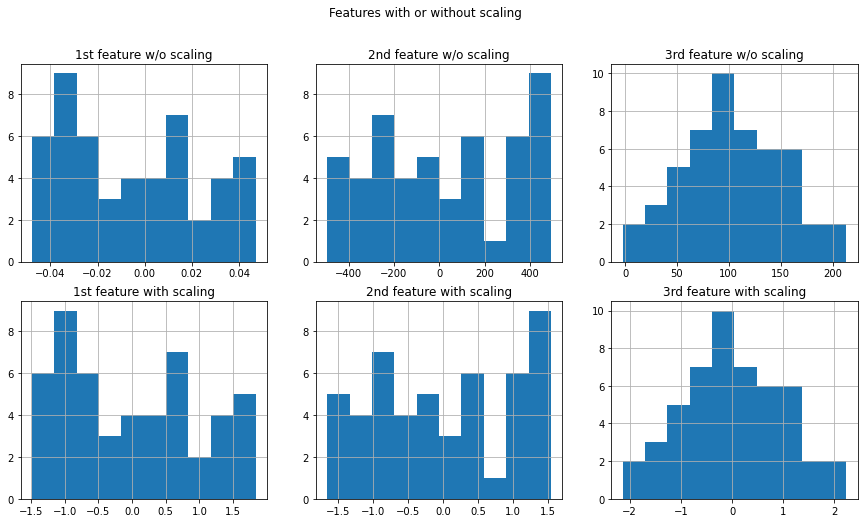

In [ ]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(15, 8)
fig.suptitle('Features with or without scaling')
axs[0, 0].hist(X_hw[:,0], bins=10)
axs[0, 1].hist(X_hw[:,1], bins=10)
axs[0, 2].hist(X_hw[:,2], bins=10)
axs[1, 0].hist(X_hw_scale[:,0], bins=10)
axs[1, 1].hist(X_hw_scale[:,1], bins=10)
axs[1, 2].hist(X_hw_scale[:,2], bins=10)
axs[0, 0].grid(True)
axs[0, 1].grid(True)
axs[0, 2].grid(True)
axs[1, 0].grid(True)
axs[1, 1].grid(True)
axs[1, 2].grid(True)
axs[0,0].set_title("1st feature w/o scaling")
axs[0,1].set_title("2nd feature w/o scaling")
axs[0,2].set_title("3rd feature w/o scaling")
axs[1,0].set_title("1st feature with scaling")
axs[1,1].set_title("2nd feature with scaling")
axs[1,2].set_title("3rd feature with scaling")
plt.show()

Выведем описательную статистику по нашим данным до и после стандартизации.

In [ ]:
pd.DataFrame(X_hw).describe()

,0,1,2
count,50.000000,50.000000,50.000000
mean,-0.005408,17.653320,103.135378
std,0.028888,312.157148,49.787228
min,-0.047942,-494.870451,-2.353457
25%,-0.031623,-243.607950,67.572919
50%,-0.006395,0.426019,99.530790
75%,0.014985,347.510534,142.353309
max,0.046991,493.572492,213.314635


In [ ]:
pd.DataFrame(X_hw_scale).describe()

,0,1,2
count,5.000000e+01,5.000000e+01,5.000000e+01
mean,-5.773160e-17,-4.440892e-18,7.849277e-16
std,1.010153e+00,1.010153e+00,1.010153e+00
min,-1.487306e+00,-1.658547e+00,-2.140304e+00
25%,-9.166974e-01,-8.454515e-01,-7.215406e-01
50%,-3.453093e-02,-5.574821e-02,-7.313488e-02
75%,7.130960e-01,1.067431e+00,7.957080e-01
max,1.832248e+00,1.540093e+00,2.235470e+00


После стандартизации данные стали симметричны относительно 0 (среднее = 0 ). Дисперсия стала примерно равна 1. Данные стали сопоставимого масштаба. Коэффициенты модели с регуляризацией L1 и L2 изменились от около нулевых до единиц. 
*   L1 :
    *   до стандартизации: 0., -0.00019299, -0.0174798 
    *   после стандартизации: 4.63705155,  0. ,        -0.12603086
*   L2 :
    *   до стандартизации: 1.34724952e+01, -1.50887784e-04, -1.72800879e-02
    *   после стандартизации: 5.06550145,  0.12151468, -0.60342419

Уменьшился квадратный корень из среднеквадратичной ошибки (RMSE).
*   L1 :
    *   до стандартизации: 6.470753262509002 
    *   после стандартизации: 4.036801696636171
*   L2 :
    *   до стандартизации: 6.171916884869858
    *   после стандартизации: 3.9759655070593736


#### **Summary**



В результате было проделанно следующее:


1.   С помощью функции PolynomialFeatures были созданы новые признаки на основе существующих в датасете и построен график зависимости ошибки модели линейной регрессии от степени новых сгенерированных признаков. По графику видно, что с увеличением степени сгенерированных признаков, растет ошибка модели на валидационных данных, при уменьшении на тренировочных. Это говорит нам о переобучении. По выбранным признакам оптимальной степенью является степень равная 2, до - недообучение, после переобучение. Более подробный анализ графика написан под заданием. 
2.   Исследовано влияние L1 и L2 регуляризации на веса модели при выбранной степени полинома для генерации признаков равной 15. Построены графики зависимости ошибки модели на тренировочных и валидационных данных, а так же усредненные веса модели для каждого из коэффициентов регуляризации. Из графиков видно уменьшение коэффициентов модели. Для обоих случаев оптимально alpha = 0.5.
3.   Проверена возможность использования L1 (Lasso) регуляризации для выбора признаков. Построен график относительного количества нулевых коэффициентов и график относительного количества не нулевых коэффициентов. По нему видно, что при выбранных признаках модель зануляет более 90% всех весов. Таким образом модель с L1 регуляризацией может избавиться от шумов в данных путем зануления весов у этих признаков.

    Так же посчитано количество нулевых признаков L2 регуляризации для всего заданного диапазона коэффициентов регуляризации alpha. Ни один коэффициент не занулен. L2 таким свойством не обладает.
4.   Рассмотренно влияние стандартизации данных на качесвтво моделей линейной регрессии с L1, L2 регуляризацией. Выведены коэффициенты моделей до и после стандартизации данных, посчитаны ошибки (RMSE). Выведены гистограммы признаков до и после стандартизации. Видно, что после стандартизации изменилась только симметричность данных отностительно 0 и изменился масштаб. После стандартизации улучшились коэффициенты моделей с L1 и L2 регуляризацией. Также уменьшилася квадратный корень из среднеквадратичной ошибки. В последнем задании данные не делились на тренировочные и валидационные, так как нам необходимо было посмотреть влияние стандартизации данных на величину коэффициентов моделей.

